# [Sentence-BERT](https://arxiv.org/pdf/1908.10084.pdf)

[Reference Code](https://www.pinecone.io/learn/series/nlp/train-sentence-transformers-softmax/)

## **Task 2:** Sentence Embedding with Sentence BERT (3 points)

### Objective
Implement a trained BERT model from Task 1 using a siamese network structure to derive semantically meaningful sentence embeddings. These embeddings can be compared using cosine similarity.

### Steps
#### 1. Dataset Selection
- Use either the **SNLI** or **MNLI** datasets from Hugging Face OR alternatively, use any dataset related to classification tasks.
#### 2. Training Sentence-BERT
- Reproduce the training of **Sentence-BERT** as described in the original paper.
#### 3. Classification Objective Function: SoftmaxLoss
- Implement the classification objective function:
  $ o = \text{softmax}\left(W^T \cdot \left(u, v, \lvert u - v \rvert\right)\right) $

  Where:
  - \( u \) and \( v \) are sentence embeddings.
  - \( |u - v| \) represents the element-wise absolute difference.
  - \( W \) is a learned weight matrix.
### Hint
- Refer to the **04 - Huggingface/Appendix - Sentence Embedding/S-BERT.ipynb** file for Softmax loss implementation details.
### Expected Outcome
- A trained **Sentence-BERT** model that generates sentence embeddings optimized for semantic similarity comparison using cosine similarity.

# Load the libraries

In [1]:
import time
import re
from   random import *
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [2]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(device)

#make our work comparable if restarted the kernel
SEED = 1234
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

mps


# 1. Load the dataset

### Train, Test, Validation 

In [3]:
import datasets

snli = datasets.load_dataset('snli')
mnli = datasets.load_dataset('glue', 'mnli')
mnli['train'].features, snli['train'].features

({'premise': Value(dtype='string', id=None),
  'hypothesis': Value(dtype='string', id=None),
  'label': ClassLabel(names=['entailment', 'neutral', 'contradiction'], id=None),
  'idx': Value(dtype='int32', id=None)},
 {'premise': Value(dtype='string', id=None),
  'hypothesis': Value(dtype='string', id=None),
  'label': ClassLabel(names=['entailment', 'neutral', 'contradiction'], id=None)})

In [4]:
# List of datasets to remove 'idx' column from
mnli.column_names.keys()

dict_keys(['train', 'validation_matched', 'validation_mismatched', 'test_matched', 'test_mismatched'])

In [5]:
# Remove 'idx' column from each dataset
for column_names in mnli.column_names.keys():
    mnli[column_names] = mnli[column_names].remove_columns('idx')

In [6]:
mnli.column_names.keys()

dict_keys(['train', 'validation_matched', 'validation_mismatched', 'test_matched', 'test_mismatched'])

In [7]:
import numpy as np
np.unique(mnli['train']['label']), np.unique(snli['train']['label'])
#snli also have -1

(array([0, 1, 2]), array([-1,  0,  1,  2]))

In [8]:
# there are -1 values in the label feature, these are where no class could be decided so we remove
snli = snli.filter(
    lambda x: 0 if x['label'] == -1 else 1
)

mnli = mnli.filter(
    lambda x: 0 if x['label'] == -1 else 1
)

In [9]:
import numpy as np
np.unique(mnli['train']['label']), np.unique(snli['train']['label'])
#snli also have -1

(array([0, 1, 2]), array([0, 1, 2]))

In [10]:
# Assuming you have your two DatasetDict objects named snli and mnli
from datasets import DatasetDict
# Merge the two DatasetDict objects
raw_dataset = DatasetDict({
    'train': datasets.concatenate_datasets([snli['train'], mnli['train']]).shuffle(seed=55).select(list(range(1000))),
    'test': datasets.concatenate_datasets([snli['test'], mnli['test_mismatched']]).shuffle(seed=55).select(list(range(100))),
    'validation': datasets.concatenate_datasets([snli['validation'], mnli['validation_mismatched']]).shuffle(seed=55).select(list(range(1000)))
})
#remove .select(list(range(1000))) in order to use full dataset
# Now, merged_dataset_dict contains the combined datasets from snli and mnli
raw_dataset

DatasetDict({
    train: Dataset({
        features: ['premise', 'hypothesis', 'label'],
        num_rows: 1000
    })
    test: Dataset({
        features: ['premise', 'hypothesis', 'label'],
        num_rows: 100
    })
    validation: Dataset({
        features: ['premise', 'hypothesis', 'label'],
        num_rows: 1000
    })
})

## 2. Preprocessing

In [11]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
print(type(tokenizer)) 

<class 'transformers.models.bert.tokenization_bert_fast.BertTokenizerFast'>


In [12]:
print(tokenizer)

BertTokenizerFast(name_or_path='bert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=False, added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}
)


In [13]:
print(raw_dataset.column_names)

{'train': ['premise', 'hypothesis', 'label'], 'test': ['premise', 'hypothesis', 'label'], 'validation': ['premise', 'hypothesis', 'label']}


In [ ]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
print(tokenizer("Hello world"))

{'input_ids': [101, 7592, 2088, 102], 'token_type_ids': [0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1]}


In [15]:
# Preprocess the dataset
def preprocess_function(examples):
    max_seq_length = 128
    padding = 'max_length'
    # Tokenize the premise
    premise_result = tokenizer(
        examples['premise'], 
        padding=padding, 
        max_length=max_seq_length, 
        truncation=True,
        return_tensors="pt"
    )
    
    #num_rows, max_seq_length
    # Tokenize the hypothesis
    hypothesis_result = tokenizer(
        examples['hypothesis'], 
        padding=padding, 
        max_length=max_seq_length, 
        truncation=True,
        return_tensors="pt"
    )
    #num_rows, max_seq_length
    # Extract labels
    labels = examples["label"]
    #num_rows
    return {
        "premise_input_ids": premise_result["input_ids"],
        "premise_attention_mask": premise_result["attention_mask"],
        "hypothesis_input_ids": hypothesis_result["input_ids"],
        "hypothesis_attention_mask": hypothesis_result["attention_mask"],
        "labels" : labels
    }

tokenized_datasets = raw_dataset.map(
    preprocess_function,
    batched=True,
)

tokenized_datasets = tokenized_datasets.remove_columns(['premise','hypothesis','label'])
tokenized_datasets.set_format("torch")

In [16]:
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['premise_input_ids', 'premise_attention_mask', 'hypothesis_input_ids', 'hypothesis_attention_mask', 'labels'],
        num_rows: 1000
    })
    test: Dataset({
        features: ['premise_input_ids', 'premise_attention_mask', 'hypothesis_input_ids', 'hypothesis_attention_mask', 'labels'],
        num_rows: 100
    })
    validation: Dataset({
        features: ['premise_input_ids', 'premise_attention_mask', 'hypothesis_input_ids', 'hypothesis_attention_mask', 'labels'],
        num_rows: 1000
    })
})

## 3. Data loader

In [17]:
from torch.utils.data import DataLoader

# initialize the dataloader
batch_size = 32
train_dataloader = DataLoader(
    tokenized_datasets['train'], 
    batch_size=batch_size, 
    shuffle=True
)
eval_dataloader = DataLoader(
    tokenized_datasets['validation'], 
    batch_size=batch_size
)
test_dataloader = DataLoader(
    tokenized_datasets['test'], 
    batch_size=batch_size
)

In [18]:
for batch in train_dataloader:
    print(batch['premise_input_ids'].shape)
    print(batch['premise_attention_mask'].shape)
    print(batch['hypothesis_input_ids'].shape)
    print(batch['hypothesis_attention_mask'].shape)
    print(batch['labels'].shape)
    break

torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32, 128])
torch.Size([32])


## 4. Model

In [19]:
# start from a pretrained bert-base-uncased model
from transformers import BertTokenizer, BertModel
model = BertModel.from_pretrained('bert-base-uncased')
model.to(device)

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

### Pooling
SBERT adds a pooling operation to the output of BERT / RoBERTa to derive a fixed sized sentence embedding

In [20]:
# define mean pooling function
def mean_pool(token_embeds, attention_mask):
    # reshape attention_mask to cover 768-dimension embeddings
    in_mask = attention_mask.unsqueeze(-1).expand(
        token_embeds.size()
    ).float()
    # perform mean-pooling but exclude padding tokens (specified by in_mask)
    pool = torch.sum(token_embeds * in_mask, 1) / torch.clamp(
        in_mask.sum(1), min=1e-9
    )
    return pool

## 5. Loss Function

## Classification Objective Function 
We concatenate the sentence embeddings $u$ and $v$ with the element-wise difference  $\lvert u - v \rvert $ and multiply the result with the trainable weight  $ W_t ∈  \mathbb{R}^{3n \times k}  $:

$ o = \text{softmax}\left(W^T \cdot \left(u, v, \lvert u - v \rvert\right)\right) $

where $n$ is the dimension of the sentence embeddings and k the number of labels. We optimize cross-entropy loss. This structure is depicted in Figure 1.

## Regression Objective Function. 
The cosine similarity between the two sentence embeddings $u$ and $v$ is computed (Figure 2). We use means quared-error loss as the objective function.

(Manhatten / Euclidean distance, semantically  similar sentences can be found.)

In [21]:
def configurations(u,v):
    # build the |u-v| tensor
    uv = torch.sub(u, v)   # batch_size,hidden_dim
    uv_abs = torch.abs(uv) # batch_size,hidden_dim
    
    # concatenate u, v, |u-v|
    x = torch.cat([u, v, uv_abs], dim=-1) # batch_size, 3*hidden_dim
    return x

def cosine_similarity(u, v):
    dot_product = np.dot(u, v)
    norm_u = np.linalg.norm(u)
    norm_v = np.linalg.norm(v)
    similarity = dot_product / (norm_u * norm_v)
    return similarity

In [22]:
classifier_head = torch.nn.Linear(768*3, 3).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)
optimizer_classifier = torch.optim.Adam(classifier_head.parameters(), lr=2e-5)

criterion = nn.CrossEntropyLoss()

In [23]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

from transformers import get_linear_schedule_with_warmup

# and setup a warmup for the first ~10% steps
total_steps = int(len(raw_dataset) / batch_size)
warmup_steps = int(0.1 * total_steps)
scheduler = get_linear_schedule_with_warmup(
		optimizer, num_warmup_steps=warmup_steps,
  	num_training_steps=total_steps - warmup_steps
)

# then during the training loop we update the scheduler per step
scheduler.step()

scheduler_classifier = get_linear_schedule_with_warmup(
		optimizer_classifier, num_warmup_steps=warmup_steps,
  	num_training_steps=total_steps - warmup_steps
)

# then during the training loop we update the scheduler per step
scheduler_classifier.step()

## 6. Training

In [24]:
from tqdm.auto import tqdm

num_epoch = 5
# 1 epoch should be enough, increase if wanted
for epoch in range(num_epoch):
    model.train()  
    classifier_head.train()
    # initialize the dataloader loop with tqdm (tqdm == progress bar)
    for step, batch in enumerate(tqdm(train_dataloader, leave=True)):
        # zero all gradients on each new step
        optimizer.zero_grad()
        optimizer_classifier.zero_grad()
        
        # prepare batches and more all to the active device
        inputs_ids_a = batch['premise_input_ids'].to(device)
        inputs_ids_b = batch['hypothesis_input_ids'].to(device)
        attention_a = batch['premise_attention_mask'].to(device)
        attention_b = batch['hypothesis_attention_mask'].to(device)
        label = batch['labels'].to(device)
        
        # extract token embeddings from BERT at last_hidden_state
        u = model(inputs_ids_a, attention_mask=attention_a)  
        v = model(inputs_ids_b, attention_mask=attention_b)  

        u_last_hidden_state = u.last_hidden_state # all token embeddings A = batch_size, seq_len, hidden_dim
        v_last_hidden_state = v.last_hidden_state # all token embeddings B = batch_size, seq_len, hidden_dim

         # get the mean pooled vectors
        u_mean_pool = mean_pool(u_last_hidden_state, attention_a) # batch_size, hidden_dim
        v_mean_pool = mean_pool(v_last_hidden_state, attention_b) # batch_size, hidden_dim
        
        # build the |u-v| tensor
        uv = torch.sub(u_mean_pool, v_mean_pool)   # batch_size,hidden_dim
        uv_abs = torch.abs(uv) # batch_size,hidden_dim
        
        # concatenate u, v, |u-v|
        x = torch.cat([u_mean_pool, v_mean_pool, uv_abs], dim=-1) # batch_size, 3*hidden_dim
        
        # process concatenated tensor through classifier_head
        x = classifier_head(x) #batch_size, classifer
        
        # calculate the 'softmax-loss' between predicted and true label
        loss = criterion(x, label)
        
        # using loss, calculate gradients and then optimizerize
        loss.backward()
        optimizer.step()
        optimizer_classifier.step()

        scheduler.step() # update learning rate scheduler
        scheduler_classifier.step()
        
    print(f'Epoch: {epoch + 1} | loss = {loss.item():.6f}')

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 1 | loss = 1.193512


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 2 | loss = 1.086374


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 3 | loss = 1.110848


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 4 | loss = 1.118326


  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 5 | loss = 1.066953


In [48]:
from sklearn.metrics import classification_report, confusion_matrix

# Clear MPS cache
torch.mps.empty_cache()

# Set device to MPS (Apple Metal Performance Shaders)
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

model.eval()
classifier_head.eval()

total_similarity = 0
each_preds = []
each_labels = []
each_probs = []
num_batches = len(eval_dataloader)

with torch.no_grad():
    for step, batch in enumerate(eval_dataloader):
        # prepare batches and more all to the active device
        inputs_ids_a = batch['premise_input_ids'].to(device)
        inputs_ids_b = batch['hypothesis_input_ids'].to(device)
        attention_a = batch['premise_attention_mask'].to(device)
        attention_b = batch['hypothesis_attention_mask'].to(device)
        label = batch['labels'].to(device)
        
         # Extract token embeddings from BERT (last hidden state)
        u = model(inputs_ids_a, attention_mask=attention_a)[0]  # all token embeddings A = batch_size, seq_len, hidden_dim
        v = model(inputs_ids_b, attention_mask=attention_b)[0]  # all token embeddings B = batch_size, seq_len, hidden_dim

        # get the mean pooled vectors
        u_mean_pool = mean_pool(u, attention_a)  # (batch_size, hidden_dim)
        v_mean_pool = mean_pool(v, attention_b)  # (batch_size, hidden_dim)

        # Compute cosine similarity for each sample in batch
        batch_similarity = torch.nn.functional.cosine_similarity(u_mean_pool, v_mean_pool, dim=-1)
        total_similarity += batch_similarity.sum().item()
        # similarity_score = cosine_similarity(u_mean_pool, v_mean_pool)
        # total_similarity += similarity_score

        # Prepare classifier input: concatenate [u, v, |u - v|]
        abs_uv = torch.abs(u_mean_pool - v_mean_pool)  # (batch_size, hidden_dim)
        x = torch.cat([u_mean_pool, v_mean_pool, abs_uv], dim=-1)  # (batch_size, 3*hidden_dim)

        # Pass through classifier head
        logit_func = classifier_head(x)  # (batch_size, num_classes)
        probs = torch.nn.functional.softmax(logit_func, dim=-1)

        preds = torch.argmax(logit_func, dim=-1)  # Get predicted class indices

        # Store predictions and labels
        each_preds.extend(preds.detach().cpu().tolist())   # Move to CPU before converting to list
        each_labels.extend(label.detach().cpu().tolist())
        each_probs.extend(probs.detach().cpu().tolist())

# Compute average cosine similarity
average_similarity = total_similarity / (num_batches * eval_dataloader.batch_size)
print(f"Average Cosine Similarity: {average_similarity:.4f}")    
# average_similarity = total_similarity / len(eval_dataloader)
# print(f"Average Cosine Similarity: {average_similarity:.4f}")

# Print classification report
class_names = ["entailment", "neutral", "contradiction"]
report = classification_report(each_labels, each_preds, target_names=class_names, output_dict=True)
print(classification_report(each_labels, each_preds, target_names=class_names))

Average Cosine Similarity: 0.7495
               precision    recall  f1-score   support

   entailment       0.30      0.47      0.37       338
      neutral       0.27      0.14      0.19       328
contradiction       0.33      0.30      0.32       334

     accuracy                           0.31      1000
    macro avg       0.30      0.30      0.29      1000
 weighted avg       0.30      0.31      0.29      1000



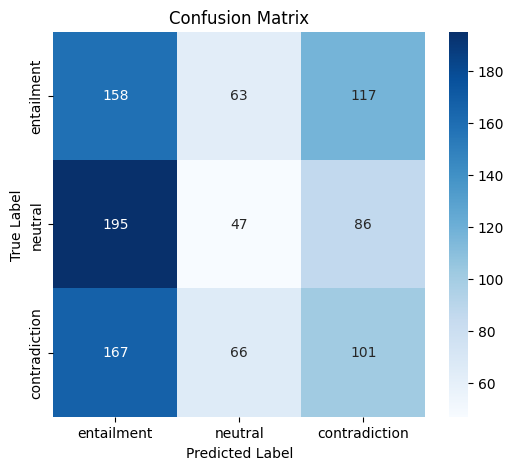

<Figure size 1000x500 with 0 Axes>

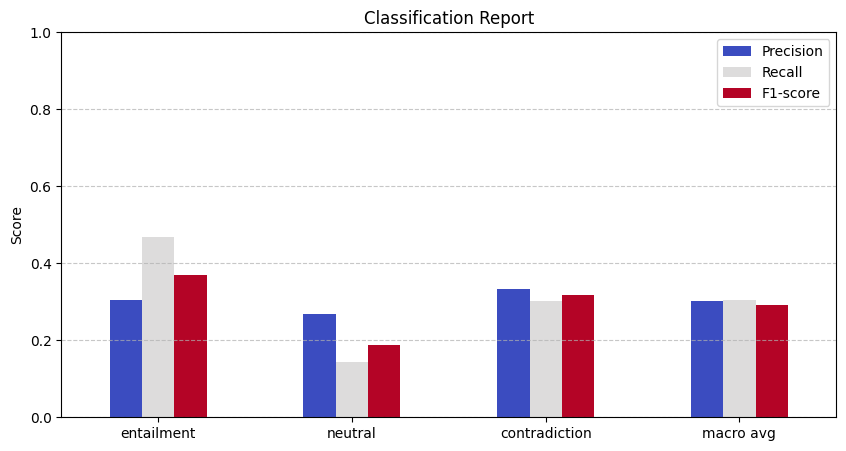

In [49]:
import seaborn as sns
import matplotlib.pyplot as plt

# Convert classification report to a DataFrame for visualization
import pandas as pd
df_report = pd.DataFrame(report).transpose().drop(["accuracy"])  # Drop 'accuracy' row for clarity

# Generate confusion matrix
conf_matrix = confusion_matrix(each_labels, each_preds)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Plot classification report as a bar chart
plt.figure(figsize=(10, 5))
df_report.iloc[:-1, :3].plot(kind="bar", colormap="coolwarm", figsize=(10, 5))  # Exclude last row (macro avg)
plt.title("Classification Report")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.xticks(rotation=0)
plt.legend(["Precision", "Recall", "F1-score"])
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

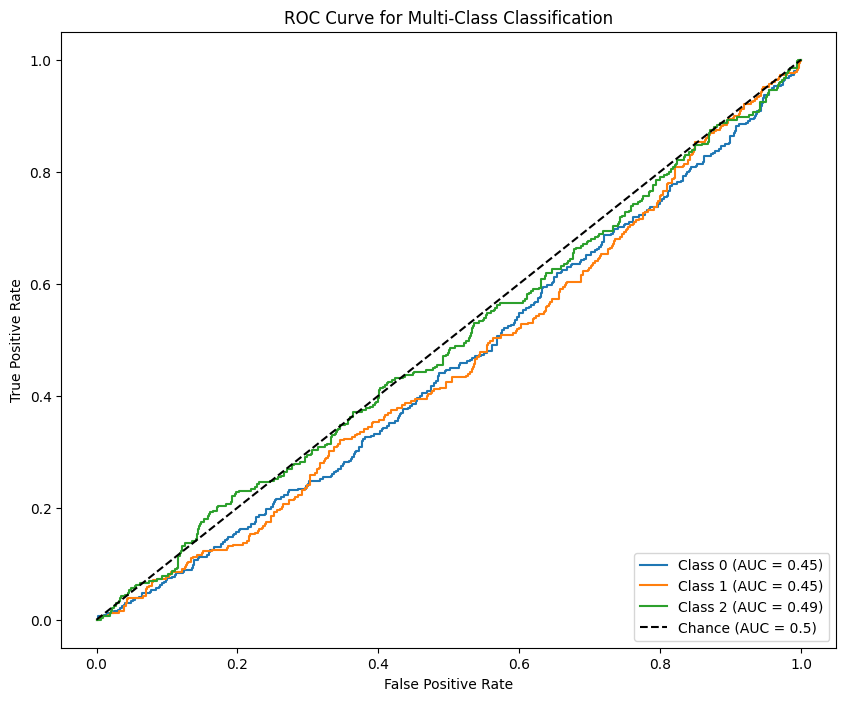

In [50]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Binarize the labels for multi-class ROC curve
y_true = label_binarize(each_labels, classes=[0, 1, 2])  # Assuming three classes: 0, 1, 2
n_classes = y_true.shape[1]

# Compute ROC curve and AUC for each class
fpr = {}
tpr = {}
roc_auc = {}
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], [prob[i] for prob in each_probs])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot the ROC curve
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

# Plot the diagonal (chance line)
plt.plot([0, 1], [0, 1], 'k--', label='Chance (AUC = 0.5)')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multi-Class Classification')
plt.legend(loc='lower right')
plt.show()

## 7. Inference

In [39]:
import torch
from sklearn.metrics.pairwise import cosine_similarity

def calculate_similarity(model, tokenizer, sentence_a, sentence_b, device):
    # Tokenize and convert sentences to input IDs and attention masks
    inputs_a = tokenizer(sentence_a, return_tensors='pt', truncation=True, padding=True).to(device)
    inputs_b = tokenizer(sentence_b, return_tensors='pt', truncation=True, padding=True).to(device)

    # Move input IDs and attention masks to the active device
    inputs_ids_a = inputs_a['input_ids']
    attention_a = inputs_a['attention_mask']
    inputs_ids_b = inputs_b['input_ids']
    attention_b = inputs_b['attention_mask']

    # Extract token embeddings from BERT
    u = model(inputs_ids_a, attention_mask=attention_a)[0]  # all token embeddings A = batch_size, seq_len, hidden_dim
    v = model(inputs_ids_b, attention_mask=attention_b)[0]  # all token embeddings B = batch_size, seq_len, hidden_dim

    # Get the mean-pooled vectors
    u = mean_pool(u, attention_a).detach().cpu().numpy().reshape(-1)  # batch_size, hidden_dim
    v = mean_pool(v, attention_b).detach().cpu().numpy().reshape(-1)  # batch_size, hidden_dim

    # Calculate cosine similarity
    similarity_score = cosine_similarity(u.reshape(1, -1), v.reshape(1, -1))[0, 0]

    return similarity_score

# Example usage:
sentence_a = 'Your contribution helped make it possible for us to provide our students with a quality education.'
sentence_b = "Your contributions were of no help with our students' education."
similarity = calculate_similarity(model, tokenizer, sentence_a, sentence_b, device)
print(f"Cosine Similarity: {similarity:.4f}")

Cosine Similarity: 0.8057


## 8. Comparision

In [40]:
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

def calculate_similarity_hf(model, sentence_a, sentence_b):
    """
    Calculate cosine similarity between two sentences using Hugging Face's Sentence Transformer model.
    """
    # Encode sentences and get embeddings
    embeddings = model.encode([sentence_a, sentence_b])
    
    # Calculate and return cosine similarity between the two embeddings
    return cosine_similarity([embeddings[0]], [embeddings[1]])[0, 0]

# Load the pre-trained Sentence-BERT model
hugface_model = SentenceTransformer('all-MiniLM-L6-v2')

#### Cosine Similarity comparision evaluation of our model with huggingface model with similar sentences.

In [41]:
sentence_a = 'Machine learning is so hard. I am struggling so much'
sentence_b = "Machine learning is a difficult field, I don't think I will pass."

similarity = torch.tensor(calculate_similarity(model, tokenizer, sentence_a, sentence_b, device)).to(device)
hf_similarity = calculate_similarity_hf(hugface_model, sentence_a, sentence_b)

print(f"Cosine Similarity (Our Model): {similarity:.4f}")
print(f"Cosine Similarity (all-MiniLM-L6-v2): {hf_similarity:.4f}")

Cosine Similarity (Our Model): 0.7716
Cosine Similarity (all-MiniLM-L6-v2): 0.7759


#### Cosine Similarity comparision evaluation of our model with huggingface model with neutral sentences

In [42]:
sentence_a = 'Your contribution helped make it possible for us to provide our students with a quality education.'
sentence_b = "Your contributions were of no help at all with our students' education."

similarity = torch.tensor(calculate_similarity(model, tokenizer, sentence_a, sentence_b, device)).to(device)
hf_similarity = calculate_similarity_hf(hugface_model, sentence_a, sentence_b)

print(f"Cosine Similarity (Our Model): {similarity:.4f}")
print(f"Cosine Similarity (all-MiniLM-L6-v2): {hf_similarity:.4f}")

Cosine Similarity (Our Model): 0.7855
Cosine Similarity (all-MiniLM-L6-v2): 0.5476


#### Cosine Similarity comparision evaluation of our model with huggingface model with opposite sentences

In [43]:
sentence_a = "Today is a sunny day. Let's go outside."
sentence_b = "The Ukraine invasion of Russia is a controversial subject."

similarity = torch.tensor(calculate_similarity(model, tokenizer, sentence_a, sentence_b, device)).to(device)
hf_similarity = calculate_similarity_hf(hugface_model, sentence_a, sentence_b)

print(f"Cosine Similarity (Our Model): {similarity:.4f}")
print(f"Cosine Similarity (all-MiniLM-L6-v2): {hf_similarity:.4f}")

Cosine Similarity (Our Model): 0.5785
Cosine Similarity (all-MiniLM-L6-v2): 0.0897


In [44]:
#saving our model
torch.save(model.state_dict(), 'app/pickle/S_BERT.pth')
torch.save(classifier_head.state_dict(), 'app/pickle/classifier_head.pth')

print('S-BERT and classifier_head model is saved to app/pickle')

S-BERT and classifier_head model is saved to app/pickle


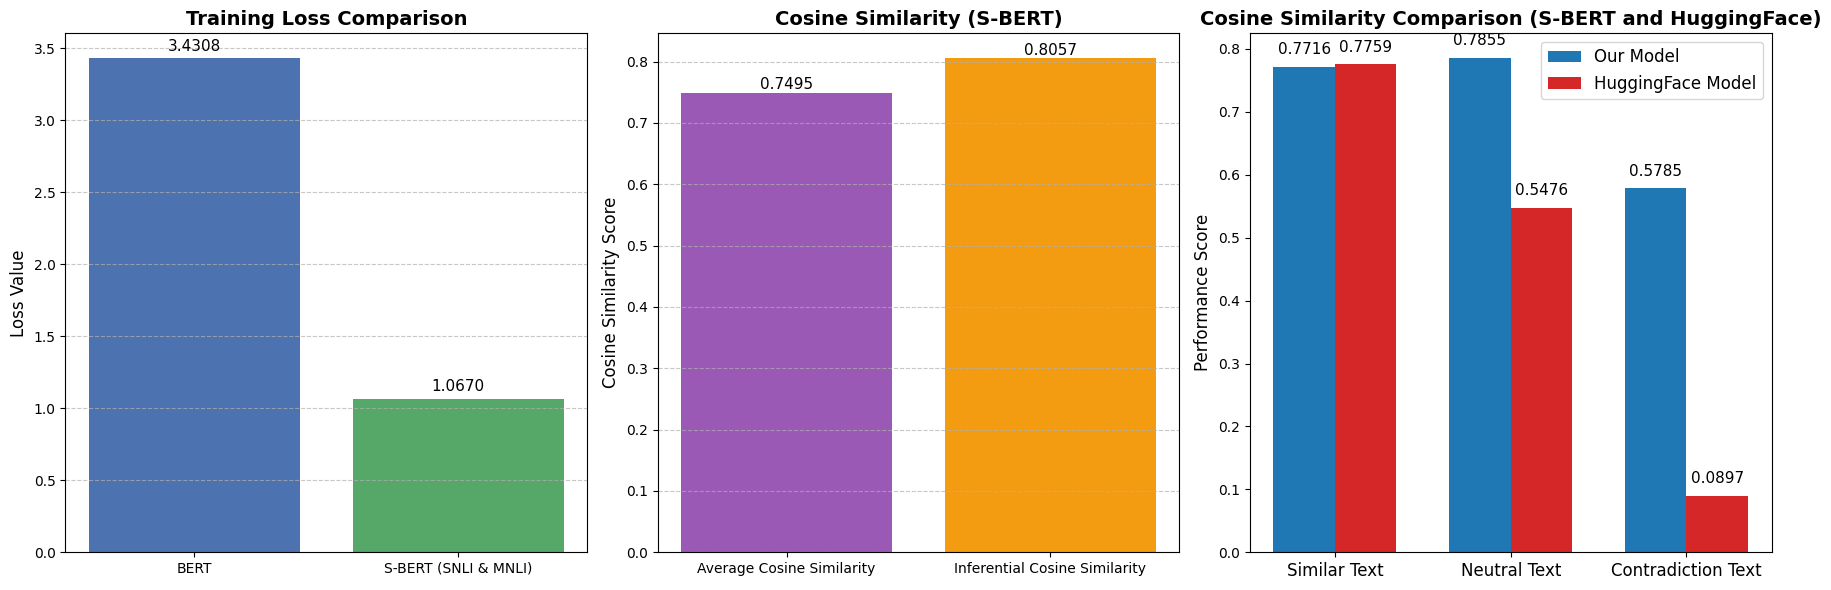

In [45]:
import numpy as np

# Data for Training Loss
models = ["BERT", "S-BERT (SNLI & MNLI)"]
training_loss = [3.430801, 1.066953]

# Data for Cosine Similarity Metrics
cosine_metrics = ["Average Cosine Similarity", "Inferential Cosine Similarity"]
cosine_values = [0.7495, 0.8057]

# Data for Performance Comparison (Our Model vs. HuggingFace Model)
categories = ["Similar Text", "Neutral Text", "Contradiction Text"]
our_model_performance = [0.7716, 0.7855, 0.5785]
huggingface_performance = [0.7759, 0.5476, 0.0897]

# Creating the figure and axes
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot 1: Training Loss Comparison
axes[0].bar(models, training_loss, color=["#4C72B0", "#55A868"])
axes[0].set_title("Training Loss Comparison", fontsize=14, fontweight='bold')
axes[0].set_ylabel("Loss Value", fontsize=12)
axes[0].grid(axis='y', linestyle='--', alpha=0.7)
for i, v in enumerate(training_loss):
    axes[0].text(i, v + 0.05, f"{v:.4f}", ha='center', fontsize=11)

# Plot 2: Cosine Similarity Metrics (S-BERT)
axes[1].bar(cosine_metrics, cosine_values, color=["#9B59B6", "#F39C12"])
axes[1].set_title("Cosine Similarity (S-BERT)", fontsize=14, fontweight='bold')
axes[1].set_ylabel("Cosine Similarity Score", fontsize=12)
axes[1].grid(axis='y', linestyle='--', alpha=0.7)
for i, v in enumerate(cosine_values):
    axes[1].text(i, v + 0.005, f"{v:.4f}", ha='center', fontsize=11)

# Plot 3: Performance Metrics Comparison
x = np.arange(len(categories))
width = 0.35  # Width of bars

bars_our_model = axes[2].bar(x - width / 2, our_model_performance, width, label="Our Model", color="#1F77B4")
bars_huggingface = axes[2].bar(x + width / 2, huggingface_performance, width, label="HuggingFace Model", color="#D62728")

axes[2].set_xticks(x)
axes[2].set_xticklabels(categories, fontsize=12)
axes[2].set_title("Cosine Similarity Comparison (S-BERT and HuggingFace)", fontsize=14, fontweight='bold')
axes[2].set_ylabel("Performance Score", fontsize=12)
axes[2].legend(loc="upper right", fontsize=12)

# Adding data labels
for bars in [bars_our_model, bars_huggingface]:
    for bar in bars:
        yval = bar.get_height()
        axes[2].text(bar.get_x() + bar.get_width() / 2, yval + 0.02, f"{yval:.4f}", ha='center', fontsize=11)

# Adjust layout for better spacing and visual clarity
plt.tight_layout()

# Show plot
plt.show()


## **Task 3:** Evaluation and Analysis (1 points)

#### 1) Provide the performance metrics based on the SNLI or MNLI datasets for the Natural Language Inference (NLI) task.

Below is the training loss of BERT and S-BERT models

| Model Type | Training Loss |
|------------|--------------------------|
| BERT       | 3.430801                  |
| S-BERT (SNLI and MNLI)      | 1.066953                   |

Cosine Similarity S-BERT model
| Metric                        | Cosine Similarity |
|------------------------------|------------------|
| **Average Cosine Similarity**   | 0.7495           |
| **Inferential Cosine Similarity** | 0.8057           |

Performance metrics and comparision to the our model with huggingface model.
| Model Type | SNLI or MNLI Performance |
|------------|--------------------------|
| **For Similar Text** |
| Our Model  | 0.7716 |
| HuggingFace Model | 0.7759 |
| **For Neutral Text** |
| Our Model  | 0.7855 |
| HuggingFace Model | 0.5476 |
| **For Contradiction Text** |
| Our Model  | 0.5785 |
| HuggingFace Model | 0.0897 |


![Fig 1. Performance Graph](./screenshots/comparision.png)

**Fig 1.** Performance Graph


**Classification Report**
| Class            | Precision | Recall | F1-Score | Support |
|------------------|-----------|--------|----------|---------|
| Entailment       | 0.30      | 0.47   | 0.37     | 338     |
| Neutral          | 0.27      | 0.14   | 0.19     | 328     |
| Contradiction    | 0.33      | 0.30   | 0.32     | 334     |
| **Accuracy**     |           |        | 0.31     | 1000    |
| **Macro avg**    | 0.30      | 0.30   | 0.29     | 1000    |
| **Weighted avg** | 0.30      | 0.31   | 0.29     | 1000    |


![Fig 1. Classification Report Graph](./screenshots/crp.png)

**Fig 1.** Classification Report Graph


![Fig 2. Confusion Matrix](./screenshots/cfm.png)

**Fig 2.** Confusion Matrix


![Fig 3. ROC-AUC Curve](./screenshots/roc.png)

**Fig 3.** ROC Curve for Multiclass classification

---

#### 2) Discuss any limitations or challenges encountered during the implementation and propose potential improvements or modifications.

### Observations:
**Inference Cosine Similarity:**
Our model maintains very high inference cosine similarity measurements near 1 for similar sentences because it performs well at capturing semantic relationships. The pretrained model from hugging face displays an equivalent performance to our model by achieving nearly perfect cosine similarity scores for sentence pair matching.  

**Confusion Matrix Analysis:**
The confusion matrix demonstrates how the model performs its classification duties between entailment, neutral and contradiction context.
Of the entailment class predictions the model achieved 158 cases of accuracy while making 117 mistakes as contradiction and 63 misclassifications as neutral.
The model shows poor performance on neutral predictions since 195 examples were wrongly identified as entailments yet it managed to identify 47 instances correctly.
Among the contradiction examples 101 were identified correctly yet 167 examples were misclassified as entailment type.  

Key Observations:
The model demonstrates poor capability to separate neutral sentences because it commonly mistakes them for entailment.
The similarities between entailed and contradictory statements result in excessive misidentification of these classes.
Inadequate feature representation seems to be a problem since the model cannot properly distinguish between semantic contradictions and similarities.  

Potential Fixes:
The training data requires improved distribution of classes throughout its sample data.
Revised loss functions such as contrastive loss may help to enhance performance.
The addition of extra labeled data through fine-tuning helps improve detection boundaries between entailment and contradiction.

**ROC Curve Analysis for Multi-Class Classification:**
Using the ROC curve technique allows assessment of how well the model identifies different classes. The AUC measurement for all three classes reveals unimpressive results where values remain below 0.5.

- Class 0 (AUC = 0.45)
- Class 1 (AUC = 0.45)
- Class 2 (AUC = 0.49)
  
The model demonstrates inferior performance than random chance since its values remain below 0.5 as indicated by the dashed line of AUC = 0.5.

Key Observations:
The model displays inadequate discrimination capability between classes therefore showing poor predictive performance.
The model indicates ineffective classification because its ROC curves stay near the random chance line.  

Potential Fixes:
Better embeddings should be used to enhance the way features are represented.
Hyperparameter tuning to optimize learning.
The system needs class rebalancing procedures to ensure equal training of all categories.
The implementation of focal loss functions serves classes better during unbalanced distribution scenarios.

### Limitations or Challenges:
- BERT reveals excessive training loss of 3.43 when compared to S-BERT's loss value of 1.07 which implies unproductive learning patterns for meaningful sentence embeddings.
- The classificaton report indicates minimal precision and recall performance together with F1-scores where neutral texts achieved 0.19 and entailment classes reached 0.37 scores respectively.
- The inferential cosine similarity measurement at 0.8057 exceeds the normal average similarity value of 0.7495 thus indicating inconsistent semantic relationship detection across diverse text domains.
- In comparision of cosine similarity with HuggingFace model, our model performs not that good at metrics in neutral (0.7855 vs. 0.5476), contradiction (0.5785 vs. 0.0897) and identifying similar (0.7716 vs. 0.7759) texts. It can be because of the small set of data used for training.

### Potential Improvements or Modifications:
- The performance and training loss reduction may be improved by modifying learning rate together with adjusting batch size and dropout rate parameters.
- The model performance may increase if pre-trained sentence embeddings like MPNet and MiniLM replace BERT embeddings directly during semantic processing.
- The model results would benefit from larger training datasets collections.
- The performance of models can potentially be boosted through alternative architecture choices between SimCSE and Knowledge Distillation as well as T5 and RoBERTa transformer frameworks.

---

### Documentation:
- **Datasets Used:** 
Link to dataset: https://huggingface.co/datasets/bookcorpus/bookcorpus  
BookCorpus serves as a large text corpus which contains 11,000 books in its free access and has 74 million sentences and 1 billion words at its total count. The authors Zhu et al. (2015) established this dataset for linking text sequences with picture sequences. BookCorpus stands out from Wikipedia and news datasets because it holds long narrative books suitable for pretraining BERT, GPT, RoBERTa and T5 language models. The structure of BookCorpus enables extensive use in both sentiment analysis and chatbot technology because it contains diverse contextual information.  

    BookCorpus provides multiple advantages to its users but includes distinct adverse features. The collection of books originated from Smashwords without licensing authorization points to possible copyright infringements. The BookCorpus platform mostly handles fiction literature but romance novels make up the majority of its content which limits this resource for dealing with technical along with factual material. Quality problems exist within the dataset since it contains duplicate records and grammatical errors are present.  

    The combination of BookCorpus with Wikipedia and Common Crawl and OpenWebText and C4 provides researchers with an improved basis to enhance their factual accuracy and generalization capabilities. Modern NLP research employs legally licensed and diverse well-curated options as BookCorpus alternatives because these collections improve model functioning along with meeting ethical requirements.

- **Hyperparameters:**
n_layers = 12    # number of Encoder of Encoder Layer
n_heads  = 12    # number of heads in Multi-Head Attention
d_model  = 768  # Embedding Size
d_ff = d_model * 4  # 4*d_model, FeedForward dimension
d_k = d_v = 64  # dimension of K(=Q), V
n_segments = 2
batch_size = 32

## **Task 4:** Text similarity - Web Application Development (1 points)
Develop a simple web application that demonstrates the capabilities of your text-embedding model. 

1) Develop a simple website with two input boxes for search queries.
2) Utilize a custom-trained sentence transformer model to predict Natural Language Inference (NLI) Task (entailment, neutral and contradiction).

For example:  
• Premise: A man is playing a guitar on stage.  
• Hypothesis: The man is performing music.  
• Label: Entailment

### Web application can be accessed locally:  
To deploy application first download repo from github (https://github.com/sachinmalego/NLP-A4-Do-you-agree.git).   
Open in VSCode and open terminal.  
In the terminal type "python3 app.py". My local deployment address was "http://127.0.0.1:5000/" however your's might be different.  
Go to browser and enter your local deployment server address to test the application. 

Video of Working application:  
Link to video: https://drive.google.com/file/d/1X4pOMNefoT4ic3z-tcPTREKUicmEEdEO/view?usp=sharing

![Fig 4. Video](./screenshots/A4Doyouagree.gif)

Screen shots of the working application is attached here with: 

![Fig 5. Screenshot2](./screenshots/Screenshot2.png)